In [1]:

import os
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.cuda.reset_peak_memory_stats()

print("Память очищена")

Память очищена


In [2]:
#!pip install torch torchvision pillow numpy pandas scikit-learn matplotlib seaborn tqdm










# ВЕРСИЯ БЕЗ МИНОРНЫХ ПРАВОК ПОСЛЕ СРОКА СДАЧИ ЛЕЖИТ НА GITHUB, В ЭТОМ НОУТБУКЕ СОДЕРЖИТСЯ ПОСЛЕДНЯЯ ВЕРСИЯ






import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from google.colab import drive

drive.mount('/content/drive')
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Mounted at /content/drive
Using device: cuda


In [3]:
import urllib.request
import zipfile
import json

dataset_path = Path('/content/drive/MyDrive/confirmed_fronts')
dataset_path.mkdir(exist_ok=True)


In [4]:
class DVMColorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
base_dir = '/content/drive/MyDrive/confirmed_fronts'
image_files = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            image_files.append(full_path)

print(f"Total images found: {len(image_files)}")

def parse_image_info(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('$$')
    if len(parts) >= 4:
        brand = parts[0]
        year = parts[2]
        color = parts[3]
        return brand, year, color, filepath
    return None, None, None, None

data = []
for path in image_files:
    brand, year, color, full_path = parse_image_info(path)
    if color is not None:
        data.append({
            'brand': brand,
            'year': year,
            'color': color,
            'full_path': full_path
        })

metadata_df = pd.DataFrame(data)
print(f"After parsing colors: {len(metadata_df)}")

metadata_df['file_exists'] = metadata_df['full_path'].apply(os.path.exists)
print(f"Existing files: {metadata_df['file_exists'].sum()}")
metadata_df = metadata_df[metadata_df['file_exists']].copy()
print(f"Files after filtering: {len(metadata_df)}")

class_counts = metadata_df['color'].value_counts()
print("Classes with fewer than 500 samples:")
print(class_counts[class_counts < 500])

valid_classes = class_counts[class_counts >= 500].index
metadata_df = metadata_df[metadata_df['color'].isin(valid_classes)].copy()

print(f"\nAfter filtering rare classes: {len(metadata_df)} samples")
print(f"Number of classes remaining: {len(valid_classes)}")

color_to_idx = {color: idx for idx, color in enumerate(sorted(valid_classes))}
idx_to_color = {idx: color for color, idx in color_to_idx.items()}
num_classes = len(color_to_idx)
print(f"Number of color classes: {num_classes}")

metadata_df['label'] = metadata_df['color'].map(color_to_idx)

image_paths = metadata_df['full_path'].values
labels = metadata_df['label'].values

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.05, random_state=42, stratify=labels
)

print(f"\nTrain samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

Total images found: 61827
After parsing colors: 61827
Existing files: 61827
Files after filtering: 61827
Classes with fewer than 500 samples:
color
Purple         362
Bronze         329
Gold           217
Multicolour    196
Pink            87
Maroon          26
Turquoise       26
Magenta          9
Burgundy         9
Navy             1
Indigo           1
Name: count, dtype: int64

After filtering rare classes: 60564 samples
Number of classes remaining: 12
Number of color classes: 12

Train samples: 57535
Validation samples: 3029


In [6]:

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
batch_size = 512

train_dataset = DVMColorDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DVMColorDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)


In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def create_custom_resnet18(num_classes):
    return CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes)


model_scratch = create_custom_resnet18(num_classes).to(device)
print(f"Custom ResNet18 created with {num_classes} classes")
print(f"Number of parameters: {sum(p.numel() for p in model_scratch.parameters()):,}")

Custom ResNet18 created with 12 classes
Number of parameters: 11,182,668


In [9]:
pretrained_model1 = models.resnet50(pretrained=True)
pretrained_model1.fc = nn.Linear(pretrained_model1.fc.in_features, num_classes)
pretrained_model1 = pretrained_model1.to(device)

pretrained_model2 = models.efficientnet_b0(pretrained=True)
pretrained_model2.classifier[1] = nn.Linear(
    pretrained_model2.classifier[1].in_features, num_classes
)
pretrained_model2 = pretrained_model2.to(device)

print("Pretrained models loaded:")
print(f"1. ResNet50 (ImageNet) - parameters: {sum(p.numel() for p in pretrained_model1.parameters()):,}")
print(f"2. EfficientNet-B0 (ImageNet) - parameters: {sum(p.numel() for p in pretrained_model2.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 157MB/s]

Pretrained models loaded:
1. ResNet50 (ImageNet) - parameters: 23,532,620
2. EfficientNet-B0 (ImageNet) - parameters: 4,022,920


In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler, scheduler=None):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

In [11]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1, all_preds, all_labels

In [12]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, model_name):
    best_f1 = 0.0
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device, scaler, scheduler)

        val_loss, val_f1, _, _ = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f'Best model saved with F1: {best_f1:.4f}')

    return history, best_f1

In [13]:
num_epochs = 30
max_learning_rate = 0.1

criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(
    model_scratch.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler_scratch = optim.lr_scheduler.OneCycleLR(
    optimizer_scratch,
    max_lr=0.1,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,           # 30% времени на разогрев
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting training with SGD + OneCycleLR")
history_scratch, best_f1_scratch = train_model(
    model_scratch, train_loader, val_loader, criterion,
    optimizer_scratch, scheduler_scratch, num_epochs, 'custom_resnet18_sgd_onecycle'
)

Starting training with SGD + OneCycleLR

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [04:10<00:00, 41.72s/it]


Train Loss: 1.0756, Train F1: 0.4143
Val Loss: 0.8506, Val F1: 0.5001
Best model saved with F1: 0.5001

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Train Loss: 0.7020, Train F1: 0.5881
Val Loss: 1.5039, Val F1: 0.3817

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Train Loss: 0.6356, Train F1: 0.6305
Val Loss: 0.9411, Val F1: 0.5512
Best model saved with F1: 0.5512

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Train Loss: 0.5702, Train F1: 0.6722
Val Loss: 0.8878, Val F1: 0.5576
Best model saved with F1: 0.5576

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Train Loss: 0.5263, Train F1: 0.6881
Val Loss: 0.6930, Val F1: 0.6306
Best model saved with F1: 0.6306

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Train Loss: 0.4837, Train F1: 0.7105
Val Loss: 0.6770, Val F1: 0.6601
Best model saved with F1: 0.6601

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Train Loss: 0.4448, Train F1: 0.7331
Val Loss: 0.5656, Val F1: 0.6832
Best model saved with F1: 0.6832

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Train Loss: 0.4098, Train F1: 0.7483
Val Loss: 0.5660, Val F1: 0.6926
Best model saved with F1: 0.6926

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Train Loss: 0.3699, Train F1: 0.7721
Val Loss: 0.6454, Val F1: 0.7058
Best model saved with F1: 0.7058

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Train Loss: 0.3369, Train F1: 0.7881
Val Loss: 0.5431, Val F1: 0.7065
Best model saved with F1: 0.7065

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Train Loss: 0.3055, Train F1: 0.8102
Val Loss: 0.5380, Val F1: 0.7114
Best model saved with F1: 0.7114

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Train Loss: 0.2692, Train F1: 0.8336
Val Loss: 0.6518, Val F1: 0.6820

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Train Loss: 0.2259, Train F1: 0.8563
Val Loss: 0.6176, Val F1: 0.7078

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Train Loss: 0.1789, Train F1: 0.8846
Val Loss: 0.6540, Val F1: 0.6897

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Train Loss: 0.1453, Train F1: 0.9062
Val Loss: 0.5909, Val F1: 0.7423
Best model saved with F1: 0.7423

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Train Loss: 0.0940, Train F1: 0.9420
Val Loss: 0.6839, Val F1: 0.7345

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Train Loss: 0.0572, Train F1: 0.9652
Val Loss: 0.6524, Val F1: 0.7515
Best model saved with F1: 0.7515

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Train Loss: 0.0305, Train F1: 0.9825
Val Loss: 0.6838, Val F1: 0.7580
Best model saved with F1: 0.7580

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Train Loss: 0.0174, Train F1: 0.9920
Val Loss: 0.6844, Val F1: 0.7678
Best model saved with F1: 0.7678

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]

Train Loss: 0.0135, Train F1: 0.9953
Val Loss: 0.6854, Val F1: 0.7631


In [14]:
learning_rate_pretrained = 0.0015
num_epochs = 40
criterion = nn.CrossEntropyLoss()


optimizer_pretrained1 = optim.Adam(
    pretrained_model1.parameters(),
    lr=learning_rate_pretrained
)

scheduler_pretrained1 = optim.lr_scheduler.OneCycleLR(
    optimizer_pretrained1,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting fine-tuning pretrained ResNet50 model")
history_pretrained1, best_f1_pretrained1 = train_model(
    pretrained_model1, train_loader, val_loader, criterion,
    optimizer_pretrained1, scheduler_pretrained1, num_epochs, 'resnet50_pretrained'
)

Starting fine-tuning pretrained ResNet50 model

Epoch 1/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Train Loss: 0.6676, Train F1: 0.6198
Val Loss: 0.4538, Val F1: 0.7506
Best model saved with F1: 0.7506

Epoch 2/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Train Loss: 0.3760, Train F1: 0.7752
Val Loss: 0.4501, Val F1: 0.7767
Best model saved with F1: 0.7767

Epoch 3/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Train Loss: 0.3245, Train F1: 0.8056
Val Loss: 0.4616, Val F1: 0.6857

Epoch 4/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Train Loss: 0.3186, Train F1: 0.8096
Val Loss: 0.4617, Val F1: 0.7492

Epoch 5/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Train Loss: 0.3105, Train F1: 0.8173
Val Loss: 0.4668, Val F1: 0.7576

Epoch 6/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Train Loss: 0.2971, Train F1: 0.8250
Val Loss: 0.5977, Val F1: 0.7342

Epoch 7/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.2794, Train F1: 0.8346
Val Loss: 0.4734, Val F1: 0.7400

Epoch 8/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.2592, Train F1: 0.8478
Val Loss: 0.4787, Val F1: 0.7742

Epoch 9/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.2227, Train F1: 0.8641
Val Loss: 0.4715, Val F1: 0.7543

Epoch 10/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Train Loss: 0.1890, Train F1: 0.8857
Val Loss: 0.4996, Val F1: 0.7918
Best model saved with F1: 0.7918

Epoch 11/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.1667, Train F1: 0.8985
Val Loss: 0.5757, Val F1: 0.7317

Epoch 12/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.1520, Train F1: 0.9117
Val Loss: 0.5884, Val F1: 0.7290

Epoch 13/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.1237, Train F1: 0.9258
Val Loss: 0.6052, Val F1: 0.7645

Epoch 14/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.1109, Train F1: 0.9318
Val Loss: 0.5390, Val F1: 0.7751

Epoch 15/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Train Loss: 0.0912, Train F1: 0.9488
Val Loss: 0.5631, Val F1: 0.7798

Epoch 16/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0790, Train F1: 0.9542
Val Loss: 0.6651, Val F1: 0.7502

Epoch 17/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0623, Train F1: 0.9641
Val Loss: 0.5875, Val F1: 0.7758

Epoch 18/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.0589, Train F1: 0.9660
Val Loss: 0.5515, Val F1: 0.7933
Best model saved with F1: 0.7933

Epoch 19/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0446, Train F1: 0.9748
Val Loss: 0.6286, Val F1: 0.7787

Epoch 20/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0422, Train F1: 0.9764
Val Loss: 0.6753, Val F1: 0.7837

Epoch 21/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.0357, Train F1: 0.9827
Val Loss: 0.6213, Val F1: 0.7995
Best model saved with F1: 0.7995

Epoch 22/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0290, Train F1: 0.9860
Val Loss: 0.5871, Val F1: 0.8013
Best model saved with F1: 0.8013

Epoch 23/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.0240, Train F1: 0.9906
Val Loss: 0.6495, Val F1: 0.8058
Best model saved with F1: 0.8058

Epoch 24/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.0197, Train F1: 0.9892
Val Loss: 0.6849, Val F1: 0.7885

Epoch 25/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0154, Train F1: 0.9930
Val Loss: 0.6955, Val F1: 0.8051

Epoch 26/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0106, Train F1: 0.9950
Val Loss: 0.6637, Val F1: 0.8165
Best model saved with F1: 0.8165

Epoch 27/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0081, Train F1: 0.9960
Val Loss: 0.7043, Val F1: 0.8132

Epoch 28/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.0063, Train F1: 0.9973
Val Loss: 0.7082, Val F1: 0.8112

Epoch 29/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0053, Train F1: 0.9980
Val Loss: 0.7072, Val F1: 0.8155

Epoch 30/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0055, Train F1: 0.9981
Val Loss: 0.7077, Val F1: 0.8134

Epoch 31/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0046, Train F1: 0.9980
Val Loss: 0.7187, Val F1: 0.8157

Epoch 32/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Train Loss: 0.0044, Train F1: 0.9982
Val Loss: 0.7224, Val F1: 0.8147

Epoch 33/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0045, Train F1: 0.9983
Val Loss: 0.7259, Val F1: 0.8204
Best model saved with F1: 0.8204

Epoch 34/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Train Loss: 0.0042, Train F1: 0.9985
Val Loss: 0.7264, Val F1: 0.8174

Epoch 35/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Train Loss: 0.0042, Train F1: 0.9984
Val Loss: 0.7214, Val F1: 0.8196

Epoch 36/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0041, Train F1: 0.9985
Val Loss: 0.7267, Val F1: 0.8168

Epoch 37/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Train Loss: 0.0040, Train F1: 0.9985
Val Loss: 0.7256, Val F1: 0.8175

Epoch 38/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.0039, Train F1: 0.9987
Val Loss: 0.7200, Val F1: 0.8185

Epoch 39/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.0039, Train F1: 0.9986
Val Loss: 0.7255, Val F1: 0.8177

Epoch 40/40
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

Train Loss: 0.0039, Train F1: 0.9986
Val Loss: 0.7251, Val F1: 0.8186


In [15]:
learning_rate_pretrained = 0.0015
num_epochs = 30

optimizer_pretrained2 = optim.Adam(
    pretrained_model2.parameters(),
    lr=learning_rate_pretrained,
    weight_decay=1e-4
)

scheduler_pretrained2 = optim.lr_scheduler.OneCycleLR(
    optimizer_pretrained2,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting fine-tuning pretrained EfficientNet-B0 model")
history_pretrained2, best_f1_pretrained2 = train_model(
    pretrained_model2, train_loader, val_loader, criterion,
    optimizer_pretrained2, scheduler_pretrained2, num_epochs, 'efficientnet_b0_pretrained'
)

print(f"\nBest F1-macro for EfficientNet-B0 (pretrained): {best_f1_pretrained2:.4f}")

Starting fine-tuning pretrained EfficientNet-B0 model

Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Train Loss: 1.1809, Train F1: 0.3999
Val Loss: 0.6444, Val F1: 0.5893
Best model saved with F1: 0.5893

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Train Loss: 0.5377, Train F1: 0.6805
Val Loss: 0.4816, Val F1: 0.7113
Best model saved with F1: 0.7113

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Train Loss: 0.4180, Train F1: 0.7563
Val Loss: 0.4765, Val F1: 0.7374
Best model saved with F1: 0.7374

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.3567, Train F1: 0.7929
Val Loss: 0.5059, Val F1: 0.7653
Best model saved with F1: 0.7653

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.3185, Train F1: 0.8147
Val Loss: 0.5898, Val F1: 0.7543

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.2849, Train F1: 0.8344
Val Loss: 0.4215, Val F1: 0.7780
Best model saved with F1: 0.7780

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Train Loss: 0.2404, Train F1: 0.8581
Val Loss: 0.4659, Val F1: 0.7551

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Train Loss: 0.2027, Train F1: 0.8744
Val Loss: 0.4181, Val F1: 0.8030
Best model saved with F1: 0.8030

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Train Loss: 0.1738, Train F1: 0.8971
Val Loss: 0.4423, Val F1: 0.7845

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Train Loss: 0.1470, Train F1: 0.9113
Val Loss: 0.4861, Val F1: 0.7963

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train Loss: 0.1340, Train F1: 0.9229
Val Loss: 0.4891, Val F1: 0.7969

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Train Loss: 0.1131, Train F1: 0.9313
Val Loss: 0.5245, Val F1: 0.7848

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.0981, Train F1: 0.9436
Val Loss: 0.5122, Val F1: 0.8156
Best model saved with F1: 0.8156

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0844, Train F1: 0.9523
Val Loss: 0.5158, Val F1: 0.7949

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


Train Loss: 0.0702, Train F1: 0.9620
Val Loss: 0.5136, Val F1: 0.8163
Best model saved with F1: 0.8163

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Train Loss: 0.0558, Train F1: 0.9662
Val Loss: 0.5308, Val F1: 0.7983

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.0466, Train F1: 0.9713
Val Loss: 0.5888, Val F1: 0.8068

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Train Loss: 0.0399, Train F1: 0.9785
Val Loss: 0.5706, Val F1: 0.8045

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Train Loss: 0.0315, Train F1: 0.9847
Val Loss: 0.5612, Val F1: 0.8091

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Train Loss: 0.0236, Train F1: 0.9902
Val Loss: 0.5721, Val F1: 0.8307
Best model saved with F1: 0.8307

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Train Loss: 0.0188, Train F1: 0.9911
Val Loss: 0.5732, Val F1: 0.8219

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Train Loss: 0.0160, Train F1: 0.9933
Val Loss: 0.6039, Val F1: 0.8295

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Train Loss: 0.0129, Train F1: 0.9946
Val Loss: 0.6100, Val F1: 0.8346
Best model saved with F1: 0.8346

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Train Loss: 0.0109, Train F1: 0.9953
Val Loss: 0.5863, Val F1: 0.8347
Best model saved with F1: 0.8347

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Train Loss: 0.0095, Train F1: 0.9955
Val Loss: 0.5948, Val F1: 0.8354
Best model saved with F1: 0.8354

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Train Loss: 0.0093, Train F1: 0.9960
Val Loss: 0.5920, Val F1: 0.8334

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Train Loss: 0.0077, Train F1: 0.9975
Val Loss: 0.5965, Val F1: 0.8376
Best model saved with F1: 0.8376

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Train Loss: 0.0079, Train F1: 0.9965
Val Loss: 0.6005, Val F1: 0.8321

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Train Loss: 0.0067, Train F1: 0.9977
Val Loss: 0.6014, Val F1: 0.8315

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

Train Loss: 0.0074, Train F1: 0.9972
Val Loss: 0.5969, Val F1: 0.8309

Best F1-macro for EfficientNet-B0 (pretrained): 0.8376


In [16]:
def evaluate_model(model, dataloader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f'Evaluating {model_name}'):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n{'='*60}")
    print(f"Results for {model_name}")
    print(f"{'='*60}")
    print(f"F1-macro: {f1_macro:.4f}")
    print(f"F1-weighted: {f1_weighted:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=[idx_to_color[i] for i in range(num_classes)]))

    return f1_macro, f1_weighted, all_preds, all_labels

In [17]:
model_scratch.load_state_dict(torch.load('custom_resnet18_sgd_onecycle_best.pth'))
pretrained_model1.load_state_dict(torch.load('resnet50_pretrained_best.pth'))
pretrained_model2.load_state_dict(torch.load('efficientnet_b0_pretrained_best.pth'))

f1_scratch, _, preds_scratch, labels_scratch = evaluate_model(
    model_scratch, val_loader, device, 'Custom ResNet18 (from scratch)'
)

f1_pretrained1, _, preds_pretrained1, labels_pretrained1 = evaluate_model(
    pretrained_model1, val_loader, device, 'ResNet50 (pretrained)'
)

f1_pretrained2, _, preds_pretrained2, labels_pretrained2 = evaluate_model(
    pretrained_model2, val_loader, device, 'EfficientNet-B0 (pretrained)'
)

Evaluating Custom ResNet18 (from scratch): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]



Results for Custom ResNet18 (from scratch)
F1-macro: 0.7678
F1-weighted: 0.8667

Classification Report:
              precision    recall  f1-score   support

       Beige       0.59      0.53      0.56        30
       Black       0.89      0.93      0.91       716
        Blue       0.90      0.87      0.88       424
       Brown       0.55      0.53      0.54        45
       Green       0.90      0.72      0.80        39
        Grey       0.82      0.84      0.83       474
      Orange       0.77      0.71      0.74        28
         Red       0.95      0.96      0.95       305
      Silver       0.83      0.87      0.85       389
    Unlisted       0.40      0.18      0.25        76
       White       0.93      0.94      0.94       470
      Yellow       0.94      0.97      0.96        33

    accuracy                           0.87      3029
   macro avg       0.79      0.76      0.77      3029
weighted avg       0.86      0.87      0.87      3029



Evaluating ResNet50 (pretrained): 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]



Results for ResNet50 (pretrained)
F1-macro: 0.8204
F1-weighted: 0.9027

Classification Report:
              precision    recall  f1-score   support

       Beige       0.73      0.73      0.73        30
       Black       0.92      0.96      0.94       716
        Blue       0.92      0.91      0.91       424
       Brown       0.73      0.67      0.70        45
       Green       0.88      0.77      0.82        39
        Grey       0.86      0.87      0.86       474
      Orange       0.82      0.82      0.82        28
         Red       0.96      0.97      0.97       305
      Silver       0.90      0.91      0.91       389
    Unlisted       0.50      0.20      0.28        76
       White       0.96      0.98      0.97       470
      Yellow       0.89      0.97      0.93        33

    accuracy                           0.91      3029
   macro avg       0.84      0.81      0.82      3029
weighted avg       0.90      0.91      0.90      3029



Evaluating EfficientNet-B0 (pretrained): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Results for EfficientNet-B0 (pretrained)
F1-macro: 0.8377
F1-weighted: 0.9041

Classification Report:
              precision    recall  f1-score   support

       Beige       0.86      0.83      0.85        30
       Black       0.91      0.97      0.94       716
        Blue       0.92      0.90      0.91       424
       Brown       0.71      0.76      0.73        45
       Green       0.97      0.79      0.87        39
        Grey       0.89      0.85      0.87       474
      Orange       0.88      0.75      0.81        28
         Red       0.96      0.98      0.97       305
      Silver       0.89      0.93      0.91       389
    Unlisted       0.52      0.21      0.30        76
       White       0.95      0.98      0.96       470
      Yellow       0.94      0.94      0.94        33

    accuracy                           0.91      3029
   macro avg       0.87      0.82      0.84      3029
weighted avg       0.90      0.91      0.90      3029



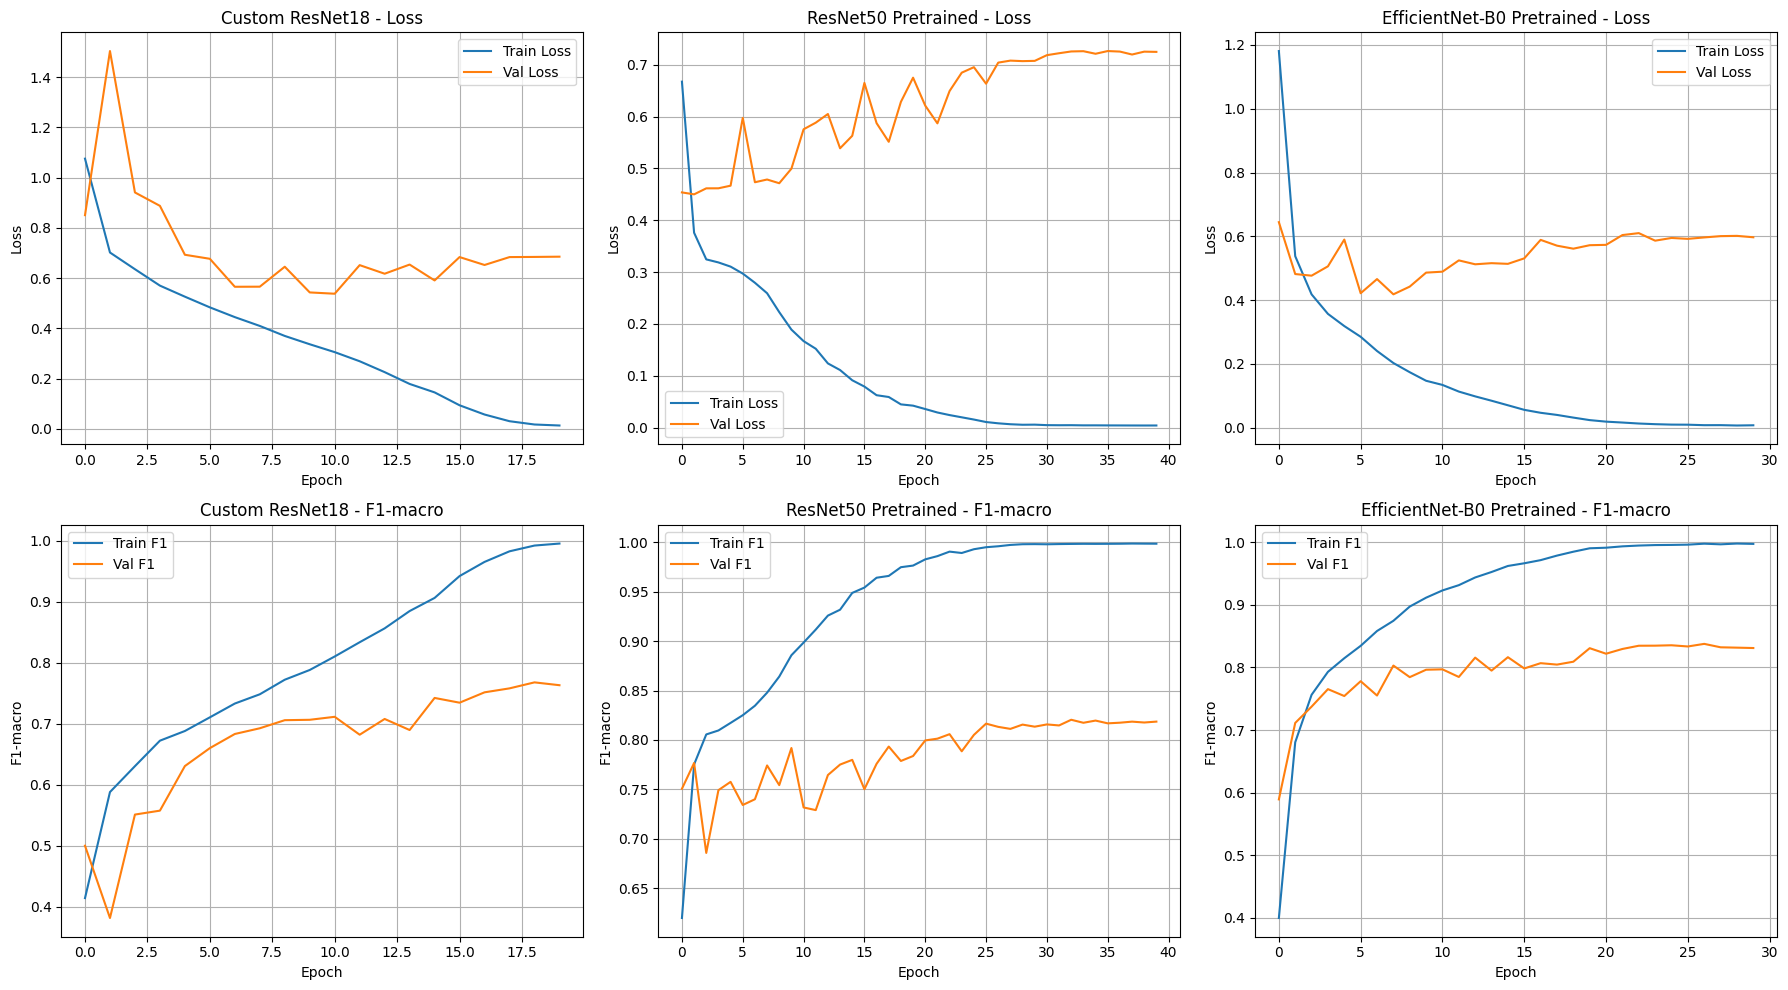

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [history_scratch, history_pretrained1, history_pretrained2]
titles = ['Custom ResNet18', 'ResNet50 Pretrained', 'EfficientNet-B0 Pretrained']

for i, (history, title) in enumerate(zip(histories, titles)):
    axes[0, i].plot(history['train_loss'], label='Train Loss')
    axes[0, i].plot(history['val_loss'], label='Val Loss')
    axes[0, i].set_title(f'{title} - Loss')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].legend()
    axes[0, i].grid(True)

    axes[1, i].plot(history['train_f1'], label='Train F1')
    axes[1, i].plot(history['val_f1'], label='Val F1')
    axes[1, i].set_title(f'{title} - F1-macro')
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel('F1-macro')
    axes[1, i].legend()
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

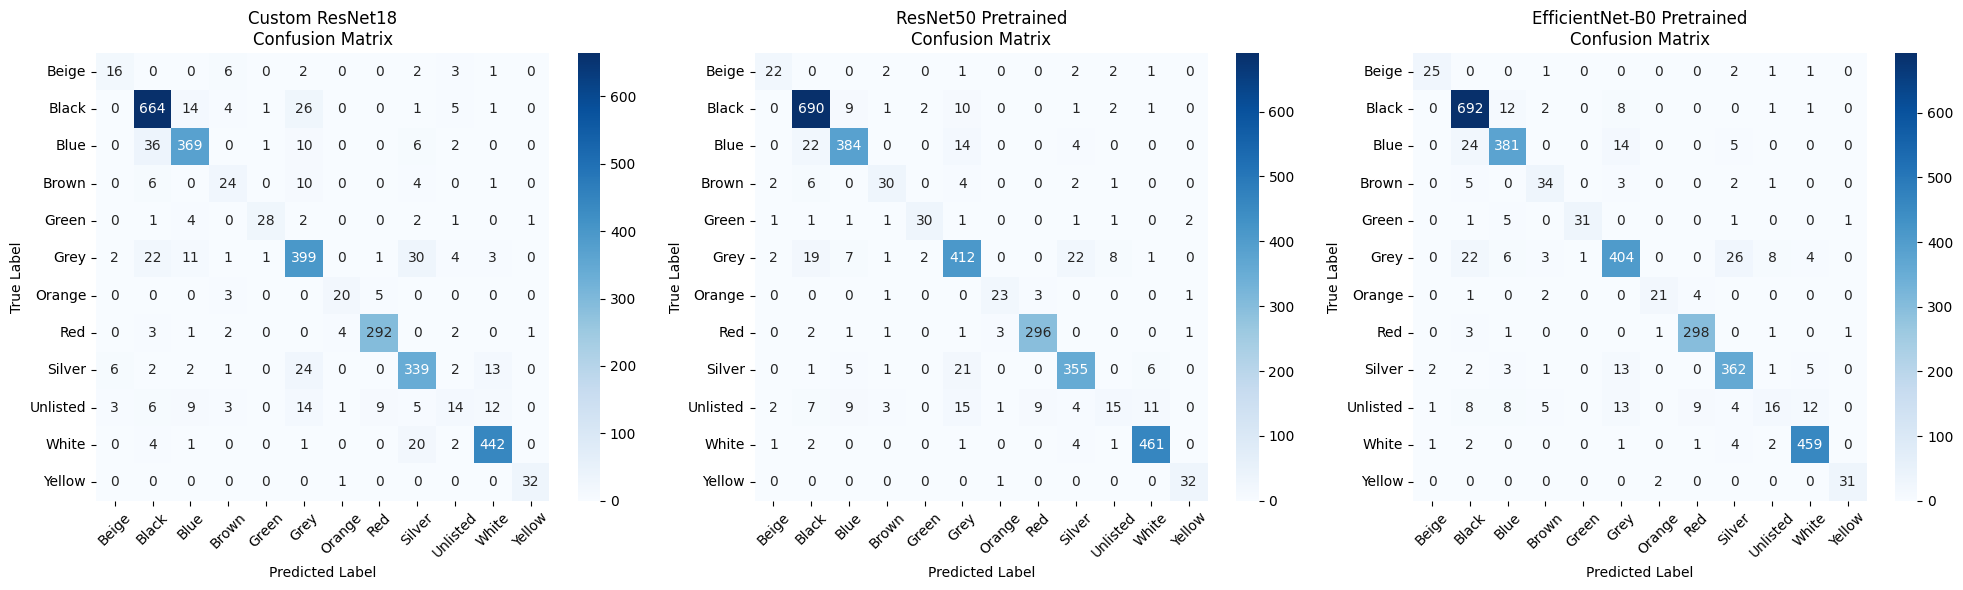

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

predictions = [preds_scratch, preds_pretrained1, preds_pretrained2]
labels_list = [labels_scratch, labels_pretrained1, labels_pretrained2]

for i, (preds, labels, title) in enumerate(zip(predictions, labels_list, titles)):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=[idx_to_color[j] for j in range(num_classes)],
                yticklabels=[idx_to_color[j] for j in range(num_classes)])
    axes[i].set_title(f'{title}\nConfusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()